In [297]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [298]:
# 廃止されたパッケージ
# from mnist import input_data
# mnist = mnist.load_mnist('MNIST_data')

In [299]:
# Eager Executionを無効にしてSessionを実行する
tf.compat.v1.disable_eager_execution()

In [300]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.compat.v1.placeholder(tf.float32, (None, real_dim), name='input_real')
    inputs_z = tf.compat.v1.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [301]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.compat.v1.variable_scope('generator', reuse=reuse):
        h1 = tf.compat.v1.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1) #Leaky ReLU
        
        logits = tf.compat.v1.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

In [302]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.compat.v1.variable_scope('discriminator', reuse=reuse):
        h1 = tf.compat.v1.layers.dense(x, n_units, activation=None)
        h1 = tf.maximum(alpha*h1, h1)
        logits = tf.compat.v1.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [303]:
#　ハイパーパラメーターの初期化

input_size = 784
z_size = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smooth = 0.1

In [304]:
# グラフの定義を行う
tf.compat.v1.reset_default_graph()
input_real, input_z = model_inputs(input_size, z_size)

g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

In [305]:
#損失関数の定義
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                            labels=tf.ones_like(d_logits_real)*(1 - smooth)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                            labels = tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                               labels=tf.ones_like(d_logits_fake)))

In [306]:
#最適化手法の定義
learning_rate = 0.002

t_vars = tf.compat.v1.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_optimize = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_optimize = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## バッチデータの確認

In [307]:
batch_size = 100
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
mnist = tf.keras.datasets.mnist.load_data()

# 28x28をフラットにする
x_train = x_train.reshape(x_train.shape[0], 784).astype('float32')

# 正規化処理
x_train = x_train / 255
x_train = x_train * 2 -1 

In [308]:
x_train.shape

(60000, 784)

In [309]:
len(mnist)

2

## トレーニングの実行

In [310]:
epochs = 100
samples = []
losses = []
saver = tf.compat.v1.train.Saver(var_list=g_vars)
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    for e in range(epochs):
        #for i in range(mnist.train.num_examples//batch_size):
        for i in range(len(x_train)//batch_size):
            # batch = mnist.train.next_batch(batch_size)
            batch_mask = np.random.choice(len(x_train), batch_size) #1バッチ分のデータ選択
            batch = x_train[batch_mask]
            # Generator
            batch_z = np.random.uniform(-1,1,size=(batch_size, z_size))
            
            _ = sess.run(d_train_optimize, feed_dict={input_real: batch, input_z: batch_z})
            _ = sess.run(g_train_optimize, feed_dict={input_z: batch_z})
            
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch})
        # train_loss_g = g_loss.eval({input_z: batch_z})
        train_loss_g = sess.run(g_loss, {input_z: batch_z})
        
        print("エポック {}/{} ".format(e+1, epochs),
        "D ロス: {:.4f} ".format(train_loss_d),
        "G ロス: {:.4f} ".format(train_loss_g))
            
        losses.append((train_loss_d, train_loss_g))
        
        sample_z = np.random.uniform(-1, 1, size=(16,z_size))
        gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                              feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
        
with open('training_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
            
            

エポック 1/100  D ロス: 0.3697  G ロス: 3.4236 
エポック 2/100  D ロス: 0.5514  G ロス: 5.0803 
エポック 3/100  D ロス: 0.6566  G ロス: 1.8991 
エポック 4/100  D ロス: 0.6305  G ロス: 2.8810 
エポック 5/100  D ロス: 1.1742  G ロス: 4.1324 
エポック 6/100  D ロス: 1.2231  G ロス: 1.4617 
エポック 7/100  D ロス: 1.9827  G ロス: 1.2143 
エポック 8/100  D ロス: 0.9630  G ロス: 2.4691 
エポック 9/100  D ロス: 1.0911  G ロス: 2.8528 
エポック 10/100  D ロス: 1.7138  G ロス: 0.8834 
エポック 11/100  D ロス: 1.0588  G ロス: 1.8486 
エポック 12/100  D ロス: 1.1374  G ロス: 1.5587 
エポック 13/100  D ロス: 0.8591  G ロス: 2.2153 
エポック 14/100  D ロス: 1.7000  G ロス: 1.4292 
エポック 15/100  D ロス: 1.6231  G ロス: 1.1057 
エポック 16/100  D ロス: 1.5711  G ロス: 1.5671 
エポック 17/100  D ロス: 0.6622  G ロス: 2.6364 
エポック 18/100  D ロス: 0.9392  G ロス: 2.0363 
エポック 19/100  D ロス: 0.9660  G ロス: 2.2851 
エポック 20/100  D ロス: 0.8202  G ロス: 2.2847 
エポック 21/100  D ロス: 0.6821  G ロス: 2.7814 
エポック 22/100  D ロス: 0.8079  G ロス: 2.0304 
エポック 23/100  D ロス: 0.8058  G ロス: 2.2276 
エポック 24/100  D ロス: 1.0108  G ロス: 1.8657 
エポック 25/100  D ロス: 0.8030

## 収束プロセスの可視化

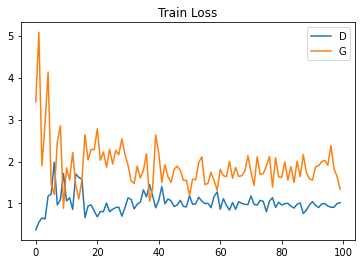

In [311]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='D')
plt.plot(losses.T[1], label='G')
plt.title('Train Loss')
plt.legend()

## イメージに変換して表示する

In [312]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax,img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
                       
    return fig, axes
        

In [313]:
with open('training_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

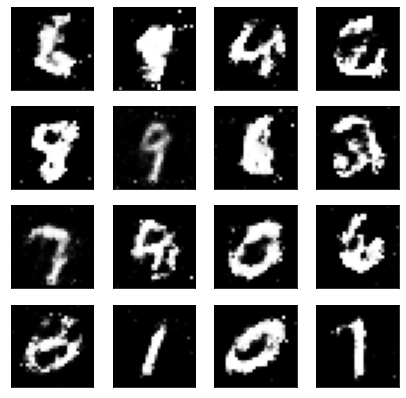

In [314]:
_ = view_samples(-1, samples)

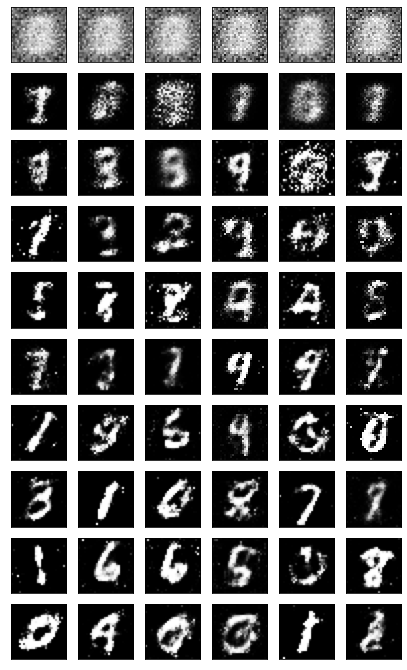

In [315]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols,sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## チェックポイントファイルから機械に画像を生成させる

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


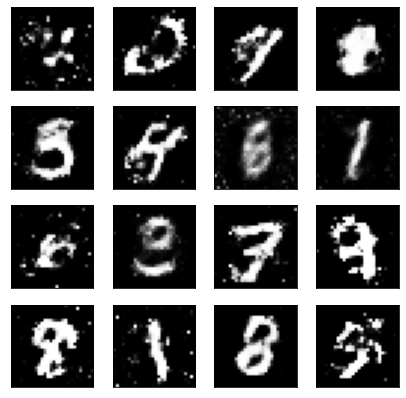

In [316]:
saver = tf.compat.v1.train.Saver(var_list=g_vars)
with tf.compat.v1.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1,1, size=(16, z_size))
    gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                          feed_dict={input_z: sample_z})
_ = view_samples(0, [gen_samples])